In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [3]:
configs = {
    "batch_size" : 128,
    "max_file_count" : 2179,
    "train_file" : 10,
    "validation_file" : 5,
    "test_file" : 5,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 3e-4,
    "scheduler_factor": 0.8,
    "scheduler_patience": 3,
    "scheduler_min_lr": 2e-5,
    "epoch" : 30,
    "model_name" : "GRU1",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/67364 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20168 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45253 [00:00<?, ?it/s]

In [5]:
torch.set_default_dtype(torch.float32)
class StockGRU(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = nn.GRU(1,self.hidden_size,2,batch_first=True,bias=False)
        self.layer2 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.LayerNorm(self.hidden_size),
            nn.Linear(self.hidden_size,1,bias=False),
        )
        self.data_scaler = 25

    def forward(self, input) :
        input = torch.multiply(input,self.data_scaler)

        h1,(hn,cn) = self.layer1(input)
        output = self.layer2(h1[:,-1,:])

        output = torch.divide(output,self.data_scaler)
        return output


In [6]:
model = StockGRU()
model = model.to(device)

print(summary(model,input_size=(configs["batch_size"],configs["input_size"],1)))

Layer (type:depth-idx)                   Param #
├─GRU: 1-1                               2,360,832
├─Sequential: 1-2                        --
|    └─Dropout: 2-1                      --
|    └─LayerNorm: 2-2                    1,024
|    └─Linear: 2-3                       512
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─GRU: 1-1                               2,360,832
├─Sequential: 1-2                        --
|    └─Dropout: 2-1                      --
|    └─LayerNorm: 2-2                    1,024
|    └─Linear: 2-3                       512
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)
loss_fn = torch.nn.MSELoss()

In [8]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "GRU.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005971422136102594
val loss :  0.0005888249684320941


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005697159075241061
val loss :  0.0006090490629260315


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005638206051120326
val loss :  0.0005886605929636699


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005598409662307364
val loss :  0.0005903516599098755


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005584502458340443
val loss :  0.0005842277262609001


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.000558018807442186
val loss :  0.0005849159072793925


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005566520684081335
val loss :  0.0005922172174812739


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.00055524852658452
val loss :  0.0005918555595662895


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005549122958962838
val loss :  0.0005930770684632763


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005529399363885318
val loss :  0.0005917348644983877


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005527224709074448
val loss :  0.00057924253030778


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005499459438476563
val loss :  0.000587305364015091


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005467938935493045
val loss :  0.0005940780652372558


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005462240212109602
val loss :  0.0005840712127195683


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005436059422374919
val loss :  0.0005857928616742182


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005407052470602187
val loss :  0.0005945638003818407


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005380116513099861
val loss :  0.0005949907509793949


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005359411382763965
val loss :  0.0005947345927814437


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005339920275004496
val loss :  0.0005946290961230933


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005294968594676114
val loss :  0.0005938697003486572


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005303955676037191
val loss :  0.0006029012920349765


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005267175714723932
val loss :  0.0006052092602698928


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005242564448364834
val loss :  0.0006056821634058668


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.000521735093494817
val loss :  0.0006065280777313243


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005196532122892621
val loss :  0.0006090768990714909


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005172432331178433
val loss :  0.0005984174430216099


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.000515579211098689
val loss :  0.0006138793373358833


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005138986543966936
val loss :  0.0006079104199566564


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005120274308934355
val loss :  0.000605883074747873


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

train loss :  0.0005098111350855085
val loss :  0.0006067078812885733


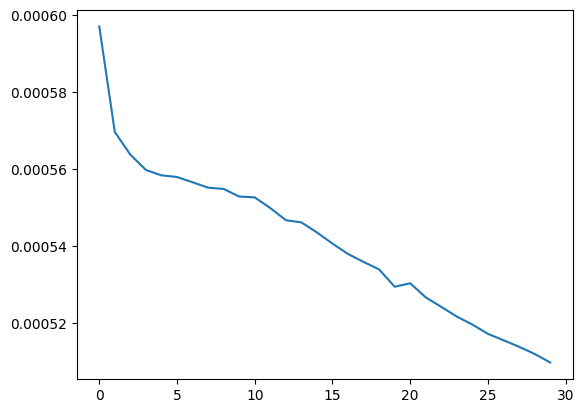

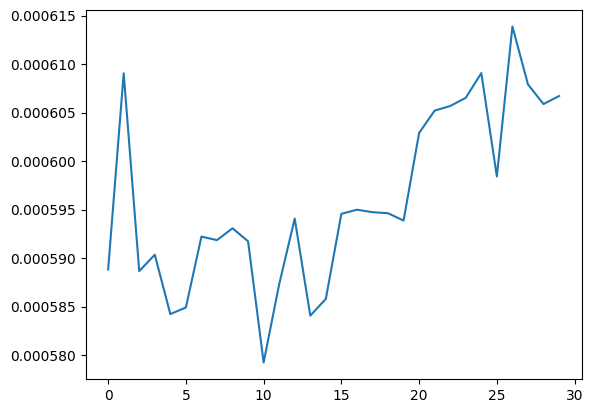

In [9]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [10]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [22]:
best_model = StockGRU()
best_model.load_state_dict(torch.load(configs["model_folder"] + "GRU.pth.tar")['model'])

best_model.to(device)
best_model.eval()    

StockGRU(
  (layer1): GRU(1, 512, num_layers=2, bias=False, batch_first=True)
  (layer2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=512, out_features=1, bias=False)
  )
)

In [23]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/354 [00:00<?, ?it/s]

0.0005272733330892837


In [24]:
def get_log_stock_prediction(model, stock_files) :
    model.eval()
    data_set = StockDatasetLogReturn(stock_files, configs["input_size"], 1)
    data_set.Preprocess()
    data_loader = DataLoader(data_set,configs["batch_size"])
    predict_res = []
    target_res = []
    
    with torch.no_grad() : 
        
        for input,target in tqdm(data_loader) :
            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)

            output = model(close_price_input)

            close_price_input = close_price_input.to(torch.device("cpu"))
            
            predict_res += output.to(torch.device("cpu")).reshape(-1).tolist()
            target_res += close_price_target.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [25]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [26]:
predict,target = get_log_stock_prediction(best_model, ["./data/A.csv"])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6129 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

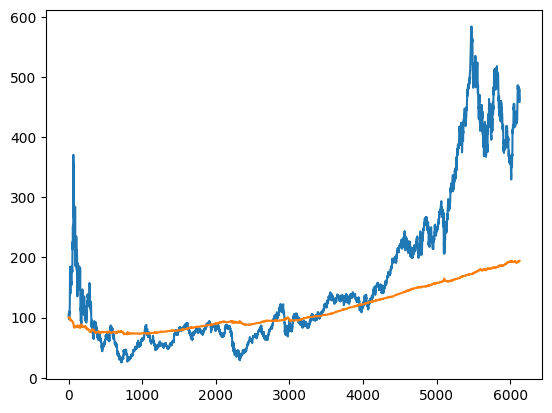

In [27]:
predict_percent = np.exp(predict)
target_percent = np.exp(target)
predict_plot = np.cumprod(predict_percent) * 100
target_plot = np.cumprod(target_percent) * 100
plt.plot(target_plot)
plt.plot(predict_plot)
plt.show()

In [28]:
total_profit = trade_test(predict,target)
print("total_profit : ",total_profit)
buy_and_hold_profit = trade_test(np.ones(target.shape),target)
print("buy and hold : ",buy_and_hold_profit)
random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
print("random profit : ",random_profit)

total_profit :  1.081059963542756
buy and hold :  4.5820224637360205
random profit :  2.3768820551683714


[]

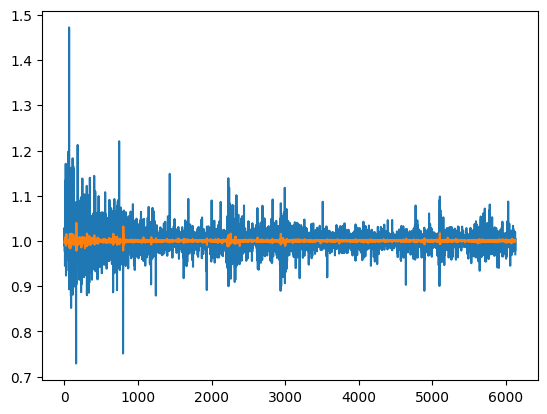

In [29]:
plt.plot(target_percent)
plt.plot(predict_percent)
plt.plot()

In [30]:
print(np.mean((np.log(np.array(target_percent)) * np.log(np.array(predict_percent))) > 0))

0.4933920704845815


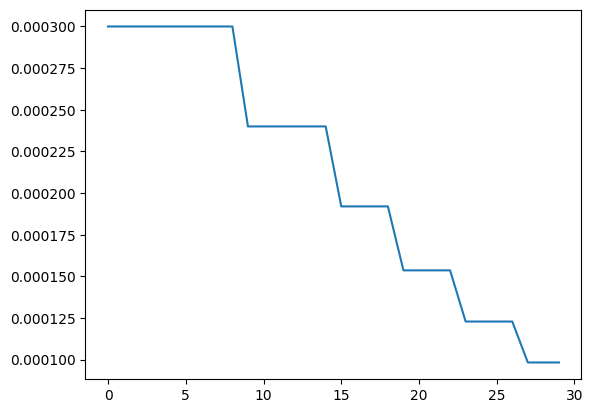

In [31]:
plt.plot(learning_rates)
plt.show()